# Modelling notebook 1: Gradient boosting

In this notebook, we build Gradient Boosted Decision Tree models for predicting fog. The data is split into a trian/validation set to make modelling decisions, and an unseen test set for checking the generalisation error of the models.

<br>

**Train-Valid:** 2011-2019  
**Test:** 2020 and 2021

Contents:
- Feature selection using cross validated XGBoost gain importace values as a measure of feature importance.
Feature importances are calculated using time-series splitted cross validation. Based on this we pick the feature list. 

- We then do some testing, adding lagged features and checking the impact on performance. 

- Finally, we tune the parameters of XGB model and export.

## 1. Import Packages & Data

In [ ]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==1.2.1

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 22.7 MB/s eta 0:00:00


In [ ]:
!pip install -U neptune-client
!pip install -U neptune-sklearn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 5.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

import neptune.new as neptune
import neptune.new.integrations.sklearn as npt_utils

The scikit-learn version is 1.2.1.


/usr/local/lib/python3.9/dist-packages/neptune/internal/backends/hosted_client.py:50: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
<ipython-input-3-53664e2ef689>:4: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune


In [ ]:
import neptune
print(neptune.__version__)

1.1.1


In [ ]:
# data processing
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import missingno
from scipy import stats

# modelling
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, \
RandomizedSearchCV, train_test_split, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier, plot_importance
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from scipy.stats import uniform, randint

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# other
from tqdm import tqdm
import pickle
import os
import sys
seed=42

In [ ]:
pd.__version__

'1.4.4'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing data and helper functions from directories dependent on which is available

joseph_path = '/content/drive/My Drive/DS_Modules/CA4021 (Final Year Project)/' # Joseph
julita_path = '/content/drive/My Drive/CA4021 (Final Year Project)/' # Julita

if os.path.exists(joseph_path):
  print("Importing from DS_Modules/CA4021")
  sys.path.append(os.path.join(joseph_path, 'scripts'))
  path = joseph_path

elif os.path.exists(julita_path):
  print("Importing directly from CA4021 folder")
  sys.path.append(sys.path.append(os.path.join(julita_path, 'scripts')))
  path = julita_path

Importing from DS_Modules/CA4021


In [ ]:
# import helper functions from aux file (prevents too much function definitions in the notebook)
from aux_functions import missing_percentages, plot_dist_discrete, plot_dist_continuous, \
plot_vis_discrete, plot_vis_continuous, month_vplot

from aux_functions_ml import preprocess, manual_cross_validate, get_feat_importance_df, \
performance_report, calc_mean_importance, plot_importance, heidke_skill_score, score_model, display_scores

In [ ]:
# import train/valid and test sets
df_train = pd.read_csv(os.path.join(path, 'data/train_data.csv'))
df_train.index=pd.to_datetime(df_train.date_time)
df_train.date_time = df_train.index

df_test = pd.read_csv(os.path.join(path, 'data/test_data.csv'))
df_test.index=pd.to_datetime(df_test.date_time)
df_test.date_time = df_test.index

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

print("Train/valid:", df_train.shape)
print("Test:", df_test.shape)

Train/valid: (78888, 57)
Test: (17544, 57)


In [ ]:
df_train.head()

,date_time,year,month,day,hour,date,dir,speed,vis,ww,w,pchar,ptend,cbl,msl,drybulb,wetbulb,dewpt,vp,rh,clow,cmedium,chigh,nlc,ntot,hlc,nsig1,tsig1,hsig1,nsig2,tsig2,hsig2,nsig3,tsig3,hsig3,nsig4,tsig4,hsig4,ceiling,dos,weather,duration,rainfall,sunshine,tabdir,tabspeed,pweather,dni,vis_hr1,target_hr1,fog_state,season,temp_dew_dist,rainfall12hma,fog_formation,fog_dissipation,transition
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,2011,1,1,0,01-Jan-2011 00:00:00,27,7,9000,10,22,5,0.1,1017.1,1027.8,5.5,4.6,3.3,7.8,86,5.0,0.0,0.0,7,7,22,7,6,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,0.0,0,0.0,0.0,0.0,26,6,0,0,9000.0,0,no fog,winter,2.2,0.0,0,0,0
2011-01-01 01:00:00,2011-01-01 01:00:00,2011,1,1,1,01-Jan-2011 01:00:00,28,6,9000,10,22,5,0.0,1017.1,1027.8,5.1,4.4,3.4,7.8,89,5.0,0.0,0.0,7,7,22,7,6,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,0.0,0,0.0,0.0,0.0,28,6,0,0,8000.0,0,no fog,winter,1.7,0.0,0,0,0
2011-01-01 02:00:00,2011-01-01 02:00:00,2011,1,1,2,01-Jan-2011 02:00:00,27,6,8000,10,22,8,0.2,1016.8,1027.5,5.3,4.0,2.1,7.1,80,5.0,0.0,0.0,7,7,22,7,6,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,0.0,0,0.0,0.0,0.0,27,7,0,0,8000.0,0,no fog,winter,3.2,0.0,0,0,0
2011-01-01 03:00:00,2011-01-01 03:00:00,2011,1,1,3,01-Jan-2011 03:00:00,25,7,8000,10,22,7,0.5,1016.6,1027.3,5.2,4.6,3.7,8.0,90,5.0,0.0,0.0,7,7,23,7,6,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23,0.0,0,0.0,0.0,0.0,27,7,0,0,8000.0,0,no fog,winter,1.5,0.0,0,0,0
2011-01-01 04:00:00,2011-01-01 04:00:00,2011,1,1,4,01-Jan-2011 04:00:00,28,7,8000,10,22,6,0.5,1016.6,1027.3,5.1,4.7,4.1,8.2,94,5.0,0.0,0.0,7,7,24,7,6,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24,0.0,0,0.0,0.0,0.0,27,7,0,0,9000.0,0,no fog,winter,1.0,0.0,0,0,0


In [ ]:
# LEAVING OUT w, ww, pweather and weather because of OH encoding sparsity

metadata = ['date', 'date_time', 'year', 'month', 'day', 'hour', 'season']
indicator = [col for col in df_train.columns if col[0] == 'i']
constant = [var for var in df_train.columns if len(df_train[var].value_counts()) == 1]
codes = ['sp1', 'sp2', 'sp3', 'sp4', 'wwa', 'wa', 'w' ,'ww', 'pweather', 'weather']
excluded = indicator + constant + codes + ['rgauge', 'sog', 'tabspeed', 'msl']
vis_vars=['target_hr1', 'vis_hr1', 'fog_formation', 'fog_dissipation', 'transition']
target = 'target_hr1'

categorical=['fog_state', 'season', 'tsig1', 'tsig2', 'tsig3', 'pchar'] #'w', 'ww', 'pweather',
             #'weather']
discrete = [var for var in df_train.columns if len(df_train[var].unique()) < 15 and 
             var not in excluded + categorical + metadata + codes + indicator + vis_vars]

continuous = [var for var in df_train.columns if var not in discrete + excluded + categorical + metadata + codes + indicator + vis_vars]
numerical = discrete+continuous
# conservative list of variables known to have an impact on fog formation.
# the other lists are too big for certain visualisations
fog_vars = ['rainfall', 'drybulb', 'cbl', 'ntot', 'dni', 'dewpt', 'speed', 'dir', 'rh']

In [ ]:
len(continuous+numerical)

56

In [ ]:
numerical

['clow',
 'cmedium',
 'chigh',
 'nlc',
 'ntot',
 'nsig1',
 'nsig2',
 'nsig3',
 'nsig4',
 'tsig4',
 'duration',
 'sunshine',
 'dir',
 'speed',
 'vis',
 'ptend',
 'cbl',
 'drybulb',
 'wetbulb',
 'dewpt',
 'vp',
 'rh',
 'hlc',
 'hsig1',
 'hsig2',
 'hsig3',
 'hsig4',
 'ceiling',
 'dos',
 'rainfall',
 'tabdir',
 'dni',
 'temp_dew_dist',
 'rainfall12hma']

## 2. Feature Selection 

In this section, we check the gain importance for each variable using xgboost. These results are averaged out using cross validation, and the performance of the model is assessed.

A final set of features is selected using the importance scores.

In [ ]:
dates = df_train.date_time
X = df_train[numerical + categorical + vis_vars].reset_index(drop=True)
y = X.pop(target)

In [ ]:
X.head()

,clow,cmedium,chigh,nlc,ntot,nsig1,nsig2,nsig3,nsig4,tsig4,duration,sunshine,dir,speed,vis,ptend,cbl,drybulb,wetbulb,dewpt,vp,rh,hlc,hsig1,hsig2,hsig3,hsig4,ceiling,dos,rainfall,tabdir,dni,temp_dew_dist,rainfall12hma,fog_state,season,tsig1,tsig2,tsig3,pchar,vis_hr1,fog_formation,fog_dissipation,transition
0,5.0,0.0,0.0,7,7,7,0.0,0.0,0.0,0.0,0.0,0.0,27,7,9000,0.1,1017.1,5.5,4.6,3.3,7.8,86,22,22,0.0,0.0,0.0,22,0.0,0.0,26,0,2.2,0.0,no fog,winter,6,0.0,0.0,5,9000.0,0,0,0
1,5.0,0.0,0.0,7,7,7,0.0,0.0,0.0,0.0,0.0,0.0,28,6,9000,0.0,1017.1,5.1,4.4,3.4,7.8,89,22,22,0.0,0.0,0.0,22,0.0,0.0,28,0,1.7,0.0,no fog,winter,6,0.0,0.0,5,8000.0,0,0,0
2,5.0,0.0,0.0,7,7,7,0.0,0.0,0.0,0.0,0.0,0.0,27,6,8000,0.2,1016.8,5.3,4.0,2.1,7.1,80,22,22,0.0,0.0,0.0,22,0.0,0.0,27,0,3.2,0.0,no fog,winter,6,0.0,0.0,8,8000.0,0,0,0
3,5.0,0.0,0.0,7,7,7,0.0,0.0,0.0,0.0,0.0,0.0,25,7,8000,0.5,1016.6,5.2,4.6,3.7,8.0,90,23,23,0.0,0.0,0.0,23,0.0,0.0,27,0,1.5,0.0,no fog,winter,6,0.0,0.0,7,8000.0,0,0,0
4,5.0,0.0,0.0,7,7,7,0.0,0.0,0.0,0.0,0.0,0.0,28,7,8000,0.5,1016.6,5.1,4.7,4.1,8.2,94,24,24,0.0,0.0,0.0,24,0.0,0.0,27,0,1.0,0.0,no fog,winter,6,0.0,0.0,6,9000.0,0,0,0


In [ ]:
model = XGBClassifier(objective='binary:logistic', random_state=seed)

Fold : 1
training size: (13148, 73)
test size: (13148, 73)
[[13026    10]
 [   76    36]]
****************************************************************************************************
Fold : 2
training size: (26296, 76)
test size: (13148, 76)
[[12957    30]
 [   71    90]]
****************************************************************************************************
Fold : 3
training size: (39444, 77)
test size: (13148, 77)
[[13036    17]
 [   39    56]]
****************************************************************************************************
Fold : 4
training size: (52592, 77)
test size: (13148, 77)
[[13046    13]
 [   60    29]]
****************************************************************************************************
Fold : 5
training size: (65740, 78)
test size: (13148, 78)
[[13081    12]
 [   37    18]]
****************************************************************************************************


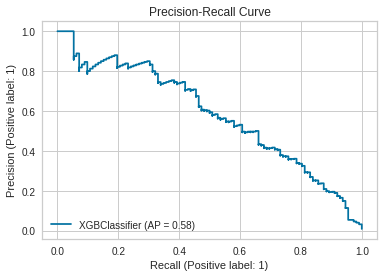

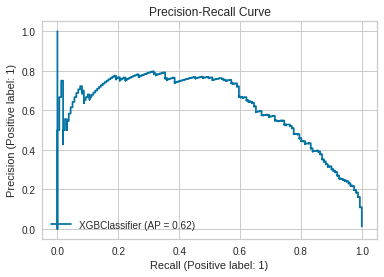

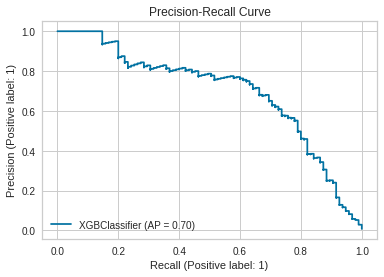

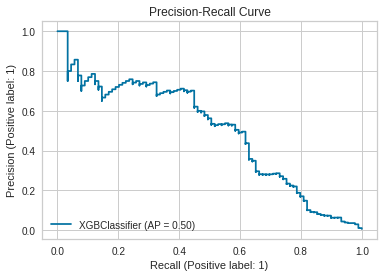

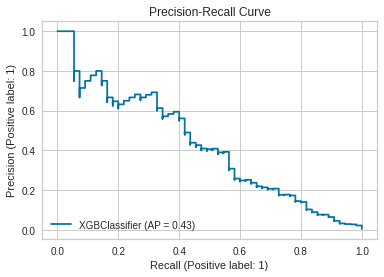

In [ ]:
full_model_scores, gain_importance_tables, _ = manual_cross_validate(model, X, y, 
                                                                     cat_vars=categorical, 
                                                                     num_vars=numerical, 
                                                                     folds=5,
                                                                     cat_encoder='oh',
                                                                     calc_feature_importance=True)


In [ ]:
performance_report(full_model_scores)

Validation Scores
------------------------------
f1_score
Scores: [45.57, 64.06, 66.67, 44.27, 42.35]
Mean: 52.584

heidke_skill_score
Scores: [0.453, 0.6368, 0.6646, 0.4403, 0.4218]
Mean: 0.523

transition_f1_score
Scores: [21.05, 31.06, 35.16, 24.44, 15.87]
Mean: 25.516

transition_hss_score
Scores: [0.0132, -0.0673, 0.0167, 0.0, -0.1042]
Mean: -0.028

pr_auc
Scores: [0.5801, 0.6134, 0.6951, 0.4919, 0.4199]
Mean: 0.560



In [ ]:
feature_importance = calc_mean_importance(gain_importance_tables)

In [ ]:
vars_sel = ['vis', 'temp_dew_dist', 'rh', 'ceiling', 'duration', 'hsig2', 'dni', 
                  'dewpt', 'drybulb', 'cbl', 'hlc', 'ntot', 'speed', 'vp', 'pchar','dir']
num_vars_sel = [var for var in vars_sel if var in discrete+continuous]
cat_vars_sel = [var for var in vars_sel if var in categorical]

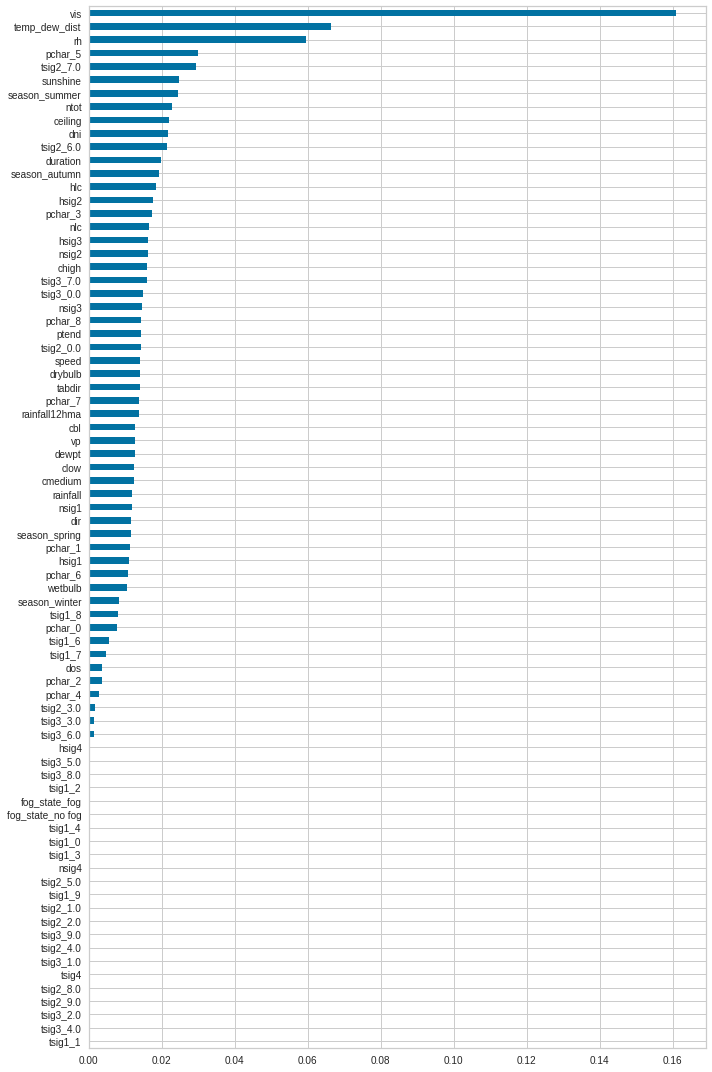

In [ ]:
plot_importance(feature_importance)

## Hyperparameter Tuning

In this section, we hyperparameter tune our gradient boosted decision tree classifier using a cross-validated randomised search approach. This will probably be updated later to a different method later.

In [ ]:
# initialise domain space for range values
# not currently in use, this will be used if we update the hyperparameter tuning approach
'''
space={
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'gamma': hp.uniform('gamma', 0, 8),
    'reg_alpha': hp.quniform('reg_alpha', 0, 100, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': 500,
    'seed': seed
    }
'''

"\nspace={\n    'max_depth': hp.quniform('max_depth', 3, 10, 1),\n    'gamma': hp.uniform('gamma', 0, 8),\n    'reg_alpha': hp.quniform('reg_alpha', 0, 100, 1),\n    'reg_lambda': hp.uniform('reg_lambda', 0, 1),\n    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),\n    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),\n    'n_estimators': 500,\n    'seed': seed\n    }\n"

In [ ]:
vars_sel = ['vis', 'temp_dew_dist', 'rh', 'ceiling', 'duration', 'hsig2', 'dni', 
                  'dewpt', 'drybulb', 'cbl', 'hlc', 'ntot', 'speed', 'vp', 'pchar','dir']
num_vars_sel = [var for var in vars_sel if var in discrete+continuous]
cat_vars_sel = [var for var in vars_sel if var in categorical]

In [ ]:
# creating training sets using only the selected features
X_train, X_test = preprocess(df_train, df_test, cat_vars=cat_vars_sel, num_vars=num_vars_sel, cat_encoder='oh')
# create training data using all the variables df_train (for comparison)
X_train_all, X_test_all = preprocess(df_train, df_test, 
                                     cat_vars=categorical, num_vars=continuous+discrete, cat_encoder='oh')
y_train = y.copy()
y_test = df_test[target]

In [ ]:
# for compatibility with TimeSeriesSplit
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
X_train.head()

,vis,temp_dew_dist,rh,ceiling,duration,hsig2,dni,dewpt,drybulb,cbl,hlc,ntot,speed,vp,dir,pchar_0,pchar_1,pchar_2,pchar_3,pchar_4,pchar_5,pchar_6,pchar_7,pchar_8
0,-1.376079,-0.362191,0.305680,-0.432978,-0.416469,-0.749357,-0.855241,-0.786384,-0.865935,1.170655,-0.002102,0.592468,-0.652624,-0.804416,0.770863,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.376079,-0.573671,0.557907,-0.432978,-0.416469,-0.749357,-0.855241,-0.763574,-0.946414,1.170655,-0.002102,0.592468,-0.833040,-0.804416,0.892206,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.445887,0.060768,-0.198772,-0.432978,-0.416469,-0.749357,-0.855241,-1.060103,-0.906174,1.145849,-0.002102,0.592468,-0.833040,-1.035018,0.770863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-1.445887,-0.658263,0.641982,-0.418409,-0.416469,-0.749357,-0.855241,-0.695144,-0.926294,1.129312,0.027427,0.592468,-0.652624,-0.738529,0.528175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.445887,-0.869742,0.978284,-0.403841,-0.416469,-0.749357,-0.855241,-0.603904,-0.946414,1.129312,0.056956,0.592468,-0.652624,-0.672643,0.892206,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
params = {'colsample_bytree': uniform(0.7, 0.3),
          'gamma': uniform(0, 0.5),
          'learning_rate': uniform(0.003, 0.3), # default 0.1 
          'max_depth': randint(2, 6), # default 3
          'n_estimators': randint(100, 500), # default 100
          'subsample': uniform(0.6, 0.4)}

xgb_model = XGBClassifier(objective="binary:logistic",random_state=seed)
time_split = TimeSeriesSplit(n_splits = 5)
xgb_search = RandomizedSearchCV(xgb_model,param_distributions=params, random_state=seed, n_iter=10, cv=time_split, verbose=3, n_jobs=1, return_train_score=True)

In [ ]:
# DON'T RERUN THIS CELL
# the results were saved and are loaded in below
# xgb_search.fit(X_train, y_train)

In [ ]:
'''
# save hyperparameter search

# Save the object to a file
with open(os.path.join(path, 'results/xgb_hyperparam_search1.pickle'), "wb") as file:
    pickle.dump(xgb_search, file)
'''

'\n# save hyperparameter search\n\n# Save the object to a file\nwith open(os.path.join(path, \'results/xgb_hyperparam_search1.pickle\'), "wb") as file:\n    pickle.dump(xgb_search, file)\n'

##  Model Evaluation

First we check the performance of the final model (features selected and hyperparameter tuned), and compare it to the initial default xgboost model (all features) using cross validation on the train/valid set (called this the validation model).

**Result:** The validation model outperforms the initial model on the train_valiation set.

After that, we train the final model with the all the train/valid data, and test it out on the unseen test set.

**Result:**
Generalisation error of the model is low, and performance is comparable to the cross validaiton results.

In [ ]:
# load hyperparameter search
#with open(os.path.join(path, 'results/xgb_hyperparam_search1.pickle'), 'rb') as file:
#  xgb_search = pickle.load(file)

In [ ]:
# error loading in parameters from binary file, so copied them here manually
best_params = {'colsample_bytree': 0.9040922615763338,
 'gamma': 0.2252496259847715,
 'learning_rate': 0.006979488347959958,
 'max_depth': 2,
 'n_estimators': 415,
 'subsample': 0.8253152871382157}

In [ ]:
vars_sel = ['vis', 'temp_dew_dist', 'rh', 'ceiling', 'duration', 'hsig2', 'dni', 
                  'dewpt', 'drybulb', 'cbl', 'hlc', 'ntot', 'speed', 'vp', 'pchar','dir']
num_vars_sel = [var for var in vars_sel if var in discrete+continuous]
cat_vars_sel = [var for var in vars_sel if var in categorical]

In [ ]:
cat_vars_sel

['pchar']

Fold : 1
training size: (13148, 24)
test size: (13148, 24)
[[13014    22]
 [   48    64]]
****************************************************************************************************
Fold : 2
training size: (26296, 24)
test size: (13148, 24)
[[12948    39]
 [   56   105]]
****************************************************************************************************
Fold : 3
training size: (39444, 24)
test size: (13148, 24)
[[13030    23]
 [   36    59]]
****************************************************************************************************
Fold : 4
training size: (52592, 24)
test size: (13148, 24)
[[13040    19]
 [   47    42]]
****************************************************************************************************
Fold : 5
training size: (65740, 24)
test size: (13148, 24)
[[13079    14]
 [   32    23]]
****************************************************************************************************


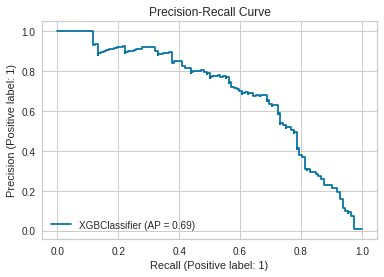

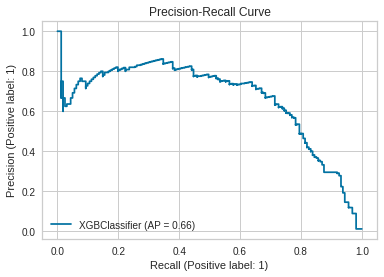

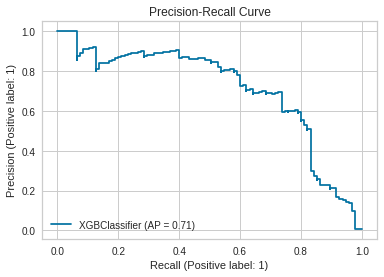

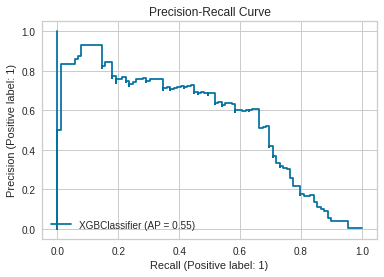

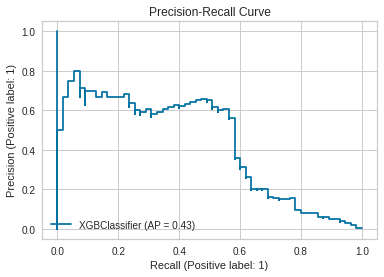

In [ ]:
validation_model = XGBClassifier(**best_params, random_state=seed)
validation_model_scores, _, _ = manual_cross_validate(model=validation_model, 
                                                 X=X, y=y,
                                                 num_vars=num_vars_sel,
                                                 cat_vars=cat_vars_sel,              
                                                 folds=5, 
                                                 calc_feature_importance=False,
                                                 cat_encoder='oh')

In [ ]:
# performance of model using all variables and no hyperparameter tuning
performance_report(full_model_scores)

NameError: ignored

In [ ]:
# after feature selection and hyperparameter tuning
# performance improvement across the board
performance_report(validation_model_scores)

Validation Scores
------------------------------
f1_score
Scores: [64.65, 68.85, 66.67, 56.0, 50.0]
Mean: 61.234

heidke_skill_score
Scores: [0.6438, 0.6849, 0.6644, 0.5576, 0.4983]
Mean: 0.610

transition_f1_score
Scores: [31.4, 32.22, 28.87, 30.77, 24.66]
Mean: 29.584

transition_hss_score
Scores: [-0.0921, -0.1731, -0.15, -0.0588, -0.1458]
Mean: -0.124

pr_auc
Scores: [0.6899, 0.6595, 0.707, 0.5408, 0.4172]
Mean: 0.603



Validation Scores
------------------------------
pr_auc
Score: 0.6081

f1
Score: 66.42

hss
Score: 0.6616

confusion_matrix
Score: [[17361    35]
 [   57    91]]

transition_f1
Score: 29.94

transition_hss
Score: -0.125



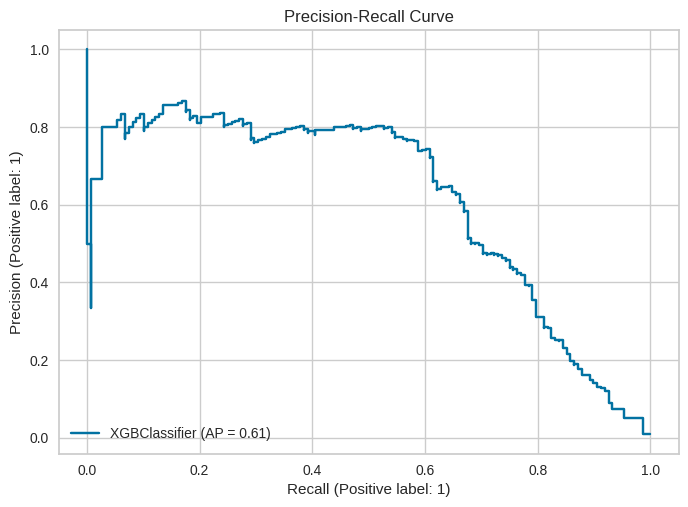

In [ ]:
# testing the updated preprocessing and training setup
X_train, X_test = preprocess(df_train, df_test, cat_vars=cat_vars_sel, num_vars=num_vars_sel, cat_encoder='oh')

y_train = y.copy()
y_test = df_test[target]


final_model = XGBClassifier(**best_params, objective='binary:logistic', random_state=seed)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

final_scores, final_plots = score_model(final_model, X_train, X_test, y_train, y_test, df_test)
performance_report(final_scores)

<ipython-input-20-94fa429b5ccc>:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/swiatej2/fyp/e/FYP-51
Validation Scores
------------------------------
pr_auc
Score: 0.6081

f1
Score: 66.42

hss
Score: 0.6616

confusion_matrix
Score: [[17361    35]
 [   57    91]]

transition_f1
Score: 29.94

transition_hss
Score: -0.125



<ipython-input-20-94fa429b5ccc>:19: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'list'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  run['features'] = vars_sel


Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 14 operations to synchronize with Neptune. Do not kill this process.
All 14 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/swiatej2/fyp/e/FYP-51/metadata


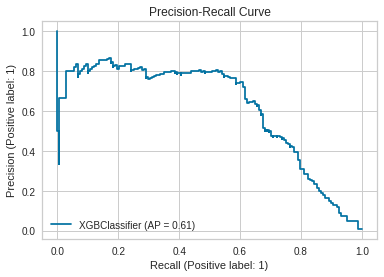

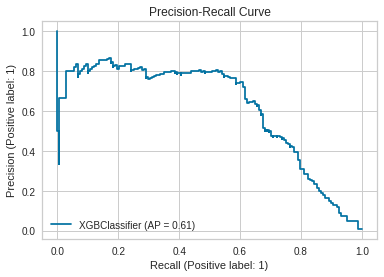

In [ ]:
run = neptune.init_run(
    project='swiatej2/fyp',
    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjOTQxYjBkZS0zN2Y1LTRhYTQtOGQ1My03YTAxODJkM2E1OWMifQ==',
    name='XGB Rerun',
    description='rerunning final XGB model with the updated transition variable',

)

final_scores, final_plots = score_model(final_model, X_train, X_test, y_train, y_test, df_test)

performance_report(final_scores)

run["algorithm"] = 'XGBoost'
run["params"] = best_params
run['metrics/f1'] = final_scores['f1']
run['metrics/hss'] = final_scores['hss']
run['metrics/transition_f1'] = final_scores['transition_f1']
run['metrics/transition_hss'] = final_scores['transition_hss']
run['features'] = vars_sel

# only include this for compatible models
run['metrics/pr_auc'] = final_scores['pr_auc']

# save Precision-Recall curve plot
img_path = os.path.join(path, 'images/xgb_pr_curve.png')
final_plots['pr_plot'].plot()
plt.title("Precision-Recall Curve")
plt.savefig(img_path)

run['plots/pr_curve'].upload(img_path)

run['plots/confusion_matrix'] = npt_utils.create_confusion_matrix_chart(final_model, X_train, X_test, y_train, y_test)

run.stop()


## Fog Formation Eval

We saw from the performance metrics that the model can predict fog states with some success, but overall fail to predict fog state transitions. As in, they can't predict accurately when a fog episode will begin. In this section, we evaluate how well the xgboost model can predict fog episodes when we give wider margins of error.

**Result:**
- When considering longer lead-times, XGBoost model caught more transitions than for just the 1 hour lead time, but not significantly more. A bigger problem is the fog formations it didn't detect at all.

**Notes:**
- Actual vs Predicted plot shows that the model is identifying fog episodes.
- Closer look at actual vs predicted tables shows that the model is underpredicting fog slightly, and the number of hourly fog instances it detected is roughly the same as the number it missed (91, 92).
- Specifically inspecting fog formation predictions, we see that out of the 42 fog formation predictions, 25 of these were too late (there was already fog). Of the other 17 where there was no fog, all of them are actually fog dissipation instances, where in the next hour the fog stopped. This suggests that the predicitions were actually late here also. **The model has a lagged reaction to fog state transition**
- Analysing the 17 cases of fog formation predictions to see if there was actually fog formation within 3 hours, 6 hours, and 12 hours, we see that when the model predicted fog, there was fog within 3 to 6 hours in 17% of cases, and within 12 hours in 23.5% of cases.
 <br>



In [ ]:
y_pred = pd.Series(y_pred, index=y_test.index, name='pred')

In [ ]:
target_df = pd.DataFrame({'pred': y_pred, 'label': y_test})

In [ ]:
# build predicted fog state transition variables
formation = []
dissipation = []
fog_flag = False
for index, row in target_df.iterrows():
  # case 1: fog formation
  if row['pred'] == 1 and not fog_flag:
    formation.append(1)
    dissipation.append(0)
    fog_flag = True
  # case 2: fog dissipation
  elif row['pred'] == 0 and fog_flag:
    dissipation.append(1)
    formation.append(0)
    fog_flag = False
  # case 3: not a fog transition
  else:
    formation.append(0)
    dissipation.append(0)

target_df['pred_formation'] = formation
target_df['pred_dissipation'] = dissipation
#target_df['pred_transition'] = np.where((target_df.pred_formation == 1)|(target_df.pred_dissipation == 1), 1, 0)

In [ ]:
target_df['formation'] = df_test['fog_formation']
target_df['dissipation'] = df_test['fog_dissipation']
target_df['fog_state'] = df_test['fog_state']

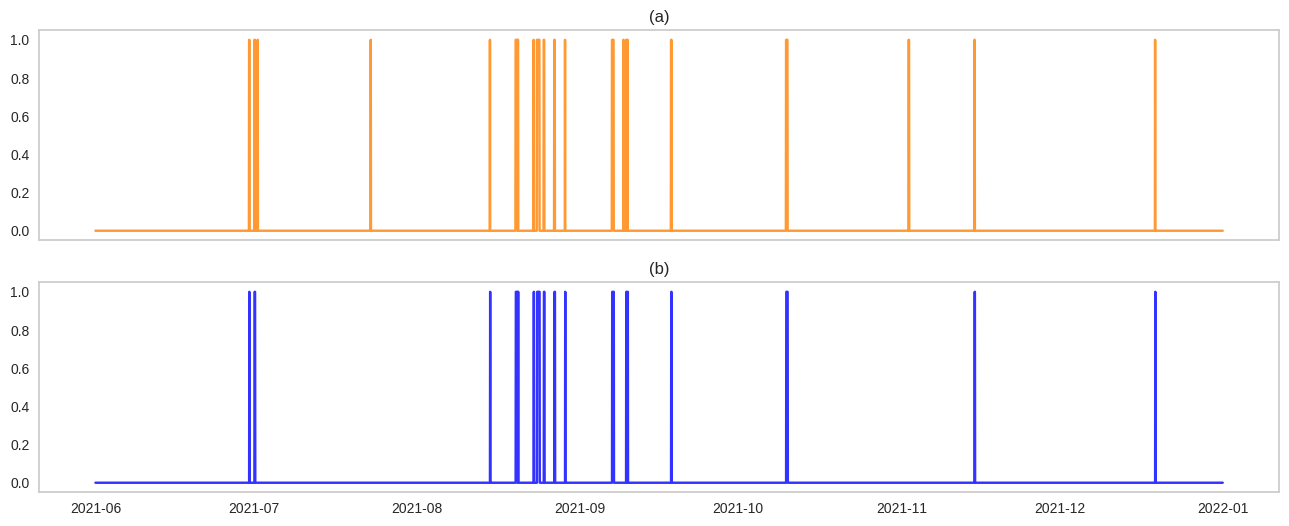

In [ ]:
# (a) is actual fog episodes in second half of 2021
# (b) is predicted fog episodes by best XGBoost model in second half of 2021
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 6), sharex=True)

ax1.plot(target_df.loc[target_df.index >= '2021-06', ['label']], 
         alpha=0.8, linestyle='-', color='#FF8000')
ax1.set_title('(a)')

ax2.plot(target_df.loc[target_df.index >= '2021-06', ['pred']], 
         alpha=0.8, linestyle='-', color='blue')
ax2.set_title('(b)')

ax1.grid(False)
ax2.grid(False)

plt.show()

In [ ]:
# model tends to underpredict fog rather than overpredict
target_df.loc[:,['pred', 'label']].value_counts()

pred  label
0     0        17361
1     1           91
0     1           57
1     0           35
dtype: int64

In [ ]:
confusion_matrix(target_df['pred'], target_df['label'])

array([[17361,    57],
       [   35,    91]])

In [ ]:
# in 17 cases,  predicts fog formation in an hour, but it didn't occur in an hour
# most of the time when the model predicts fog formation, there is already fog. (25/42)
target_df.loc[:,['pred_formation', 'label']].value_counts()

pred_formation  label
0               0        17379
                1          123
1               1           25
                0           17
dtype: int64

In [ ]:
# the model didn't predict any fog formations correctly with 1hr lead time.
target_df.loc[:,['pred_formation', 'formation']].value_counts()

pred_formation  formation
0               0            17450
                1               52
1               0               42
dtype: int64

In [ ]:
# get the indices of target_df where fog formation predicted but there wasn't fog yet.
td_no_idx = target_df.reset_index()
pred_form_idx = td_no_idx.loc[(td_no_idx['pred_formation'] == 1) & (td_no_idx['label'] == 0), ['pred', 'pred_formation', 'label']].index

In [ ]:
# all the cases of predicted formation in next hour were actually cases of fog dissipating in the next hour!
# suggests the prediction is late in these cases
td_no_idx.iloc[pred_form_idx]

,date_time,pred,label,pred_formation,pred_dissipation,formation,dissipation,fog_state
5455,2020-08-15 07:00:00,1,0,1,0,0,1,fog
5516,2020-08-17 20:00:00,1,0,1,0,0,1,fog
5550,2020-08-19 06:00:00,1,0,1,0,0,1,fog
5563,2020-08-19 19:00:00,1,0,1,0,0,1,fog
6334,2020-09-20 22:00:00,1,0,1,0,0,1,fog
6670,2020-10-04 22:00:00,1,0,1,0,0,1,fog
7540,2020-11-10 04:00:00,1,0,1,0,0,1,fog
8208,2020-12-08 00:00:00,1,0,1,0,0,1,fog
8262,2020-12-10 06:00:00,1,0,1,0,0,1,fog
8264,2020-12-10 08:00:00,1,0,1,0,0,1,fog


In [ ]:
# for each index in pred_form_idx, check the next indices for fog formation.
n_cases = len(pred_form_idx)
three_hr = 0
six_hr = 0
twelve_hr = 0
for idx in pred_form_idx:
  # 3hr lead time
  if any(td_no_idx.iloc[idx:idx+4,-3] == 1):
    twelve_hr += 1
    six_hr += 1
    three_hr += 1
  # 6hr lead time - if formation within 6 hrs, then formation within 12 also
  elif any(td_no_idx.iloc[idx:idx+7,-3] == 1):
    six_hr += 1
    twelve_hr += 1
  elif any(td_no_idx.iloc[idx:idx+13,-3] == 1):
    twelve_hr += 1

In [ ]:
three_hr_prop = np.round((three_hr / n_cases)*100, 2)
six_hr_prop = np.round((six_hr / n_cases)*100, 2)
twelve_hr_prop = np.round((twelve_hr / n_cases)*100, 2)

In [ ]:
print("XGBoost fog onset predictions")
print("three hr lead time: {}/{}".format(three_hr, n_cases))
print("six hr lead time: {}/{}".format(six_hr, n_cases))
print("twelve hr lead time: {}/{}".format(twelve_hr, n_cases))

XGBoost fog onset predictions
three hr lead time: 3/17
six hr lead time: 3/17
twelve hr lead time: 4/17


In [ ]:
print("% Of cases where model predicts fog and fog occurs within 3 hours: {}".format(three_hr_prop))
print("% Of cases where model predicts fog and fog occurs within 6 hours: {}".format(six_hr_prop))
print("% Of cases where model predicts fog and fog occurs within 12 hours: {}".format(twelve_hr_prop))

% Of cases where model predicts fog and fog occurs within 3 hours: 17.65
% Of cases where model predicts fog and fog occurs within 6 hours: 17.65
% Of cases where model predicts fog and fog occurs within 12 hours: 23.53


In [ ]:
twelve_hr

4